# Домашнее задание 2. Преобразование данных

Цель этого задания -- преобразовать имеющиеся атрибуты пользователей в признаки так, чтобы полученная матрица признаков была пригодна для подачи в алгоритм кластеризации. Этап конструирования признаков -- самый важный и обычно самый долгий. К нему возвращаются много раз на протяжении решения задачи анализа данных.

Кроме библиотек, использованных в первом задании, нам понадобятся следующие библиотеки:
1. [scikit-learn](http://scikit-learn.org/stable/) -- библиотека, реализующая множество алгоритмов машинного обучения и сопутствующих алгоритмов

In [68]:
import csv
import re
import dateutil

import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as sp
import pandas as pd
from pandas import DataFrame, Series

np.set_printoptions(linewidth=150, precision=3, suppress=True)

# Plotting config
%matplotlib inline

In [69]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None
df_users = pd.read_csv("../hw1/files/hw1_out.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC, converters={"created_at": ts_parser})
# Remove rows with users not found
df_users = df_users[pd.notnull(df_users['name'])]
df_users["lat"].fillna(value=0, inplace=True)
df_users["lon"].fillna(value=0, inplace=True)

Далее необходимо ввести новые признаки. Для каждого пользователя предлагается ввести следующие признаки:
- name_words - количество слов в имени
- screen_name_length - количество символов в псевдониме
- description_length - длина описания
- created_year - год создания аккаунта
- country_code - код страны
- verified - предлагается перевести в тип int

In [70]:
set_of_country_codes = set(df_users['country_code'].tolist())
country_code_hash_dict = {code: i for (i, code) in
                              enumerate(set_of_country_codes)}

def get_country_code_feature(country_attribute):
    return pd.Series([country_code_hash_dict[country_attribute]],
                     name="country_code")

def get_created_year_feature(created_at_attribute):
    return pd.Series([created_at_attribute.year],
                     name="created_year")

def get_description_length_feature(description_attribute):
    if pd.isnull(description_attribute):
        return pd.Series([0])
    return pd.Series([len(description_attribute)],
                     name="description_length")

def get_screen_name_length_feature(screen_name_attribute):
    return pd.Series([len(screen_name_attribute)],
                     name="screen_name_length")

def get_name_words_feature(name_attribute):
    return pd.Series([len(name_attribute.split(' '))],
                     name="name_words")

def create_new_features(df_users, features):
    # Introduce new features
    new_features = ["name_words", "screen_name_length", "description_length", "created_year", "country_code", "verified"]
    
    # Add new_features to features
    # place your code here
    features += new_features
    
    # Calculate new features and place them into data frame
    # place tour code here
    df_users["name_words"] = df_users["name"].apply(get_name_words_feature)
    df_users['screen_name_length'] = df_users["screen_name"].apply(get_screen_name_length_feature)
    df_users['description_length'] = df_users["description"].apply(get_description_length_feature)
    df_users['created_year'] = df_users["created_at"].apply(get_created_year_feature)
    df_users['country_code'] = df_users["country_code"].apply(get_country_code_feature)
    df_users["verified"] = df_users["verified"].astype('b') # http://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html
    
    return df_users, features

In [71]:
features = ["lat", "lon", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
df_users, features = create_new_features(df_users, features)


def f(x):
    if x[0] == 1:
        return 1
    if x[1] == 1:
        return 2
    if x[2] == 1:
        return 3

x = df_users[features].values
y = df_users[['is_1', 'is_2', 'is_3']].apply(f, axis=1)

Посмотрим, являются ли какие-либо из выбранных признаков сильно скоррелированными. Для этого посчитаем матрицу корреляций и выберем те пары признаков, фбсолютное значения коэффициента корреляции между которыми больше 0.2. Необходимо реализовать функцию find_correlated_features, в которой нужно рассчитать коэффициенты корелляции и вывести те, которые больше 0.2. Подсказка: предлагается найти необходимую функцию в библиотеке np и реализовать find_correlated_features с использованием не более 5 строк кода.

In [72]:
def find_correlated_features(x, features):
    corrcoef = np.corrcoef(x, rowvar=0)
    target_corrcoef = np.nonzero(np.triu(abs(corrcoef) > 0.2, 1).astype('b'))
    target_corrcoef_ids = zip(*target_corrcoef)
    for (i,j) in target_corrcoef_ids:
        print "Correlated features: %s + %s -> %s" % (features[i], features[j], corrcoef[i, j])

In [73]:
find_correlated_features(x, features)

Correlated features: lat + lon -> -0.599680928686
Correlated features: lat + country_code -> 0.513638275216
Correlated features: lon + country_code -> -0.26694721478
Correlated features: followers_count + friends_count -> 0.209712768993
Correlated features: followers_count + listed_count -> 0.821884905627
Correlated features: followers_count + verified -> 0.288463717631
Correlated features: statuses_count + favourites_count -> 0.325421846815
Correlated features: statuses_count + created_year -> -0.205971962277
Correlated features: listed_count + verified -> 0.355211037055


Выделилось 3 группы признаков:
1. Основанные на географии:  "lat", "lon", "country_code"
2. Основанные на социальной активности:  "verified", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year"
3. Остальные:  "name_words", "screen_name_length", "description_length"

Построим взаимные распределения пар признаков в каждой из групп, а также гистограмму значений каждого из признаков с учетом целевой переменной.

Необходимо реалищовать функции: plot_two_features_scatter для построения взаимного распределения пары признаков, plot_feature_histogram для построения гистограммы значений, plot_dataset для построения набора графиков по разным парам признаков.

In [74]:
LABEL_COLORS = {1: 'red', 2: 'green', 3: 'yellow'}

def plot_two_features_scatter(x_i, x_j, y):
    
    # Set colors and plot scatter
    # your code here
    plt.scatter(x_j, x_i, s=30, c=y.apply(lambda x: LABEL_COLORS[x]))

    
def plot_feature_histogram(x_i, y):
    
    # Compute positive and negative histograms
    # your code here
    x_i__1 = x_i[np.nonzero(y == 1)]
    x_i__2 = x_i[np.nonzero(y == 2)]
    x_i__3 = x_i[np.nonzero(y == 3)]
    
    # Plot stacked barplots
    # your code here
    plt.hist([x_i__1, x_i__2, x_i__3], color=LABEL_COLORS.values(), bins=10)


def plot_dataset(x, y, features):
    # Tune your plot if necessary
    # your code here
    SUBPLOTS = len(features)
    SUBPLOT_SIZE = 4
    SUBPLOTS_MATRIX = np.array(range(1, SUBPLOTS**2 + 1)).reshape((SUBPLOTS, SUBPLOTS))
    
    plt.figure(figsize=(SUBPLOT_SIZE*SUBPLOT_SIZE, SUBPLOT_SIZE*SUBPLOT_SIZE))

    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            # Tune your plot if necessary (for example set labels)
            # your code here
            SUBPLOT_NUMBER = SUBPLOTS_MATRIX[i, j]

            ax = plt.subplot(SUBPLOTS, SUBPLOTS, SUBPLOT_NUMBER)
            ax.set_xticks([]); ax.set_yticks([])
            if SUBPLOT_NUMBER <= SUBPLOTS:
                plt.title(feature_j)
            if SUBPLOT_NUMBER % SUBPLOTS == 1:
                plt.ylabel(feature_i)

            # Do actual plotting
            if i != j:
                plot_two_features_scatter(x[:, i], x[:, j], y)            
            else:
                plot_feature_histogram(x[:, i], y)

Построим попарные распределения географических признаков ([подсказка](http://anokhin.github.io/img/hw2_geo.png)).

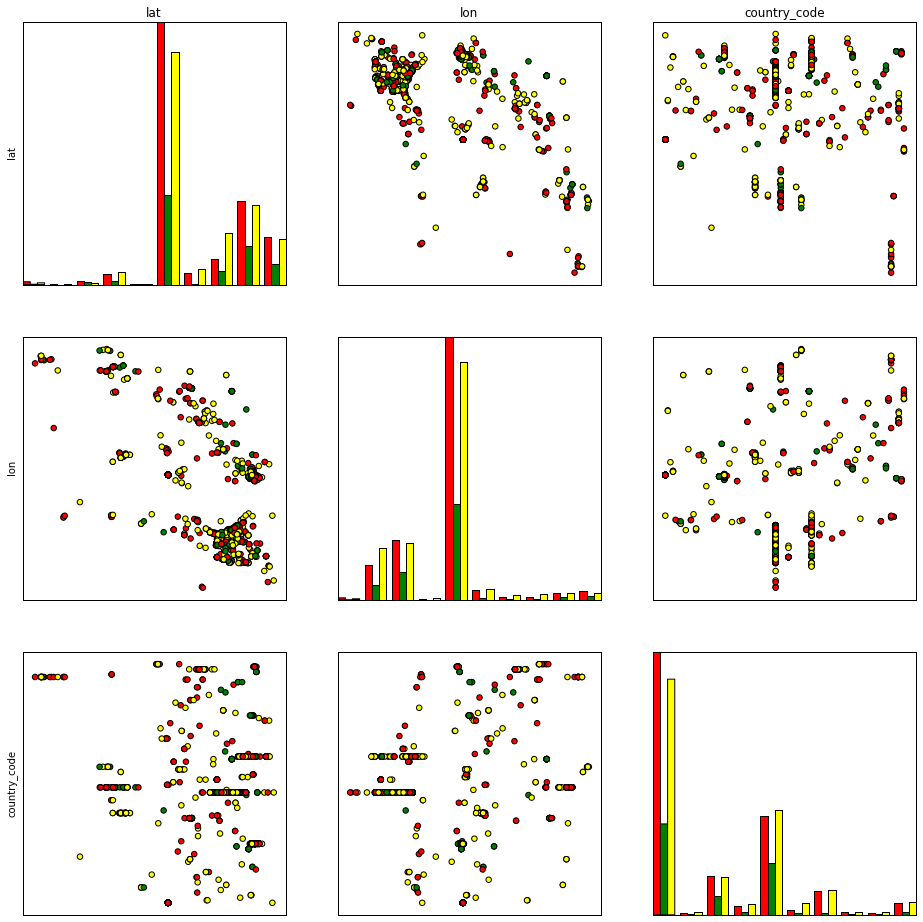

In [75]:
geo_features_new = ["lat", "lon", "country_code"]
geo_features = [f for f in geo_features_new if f in features]

geo_feature_ind = [features.index(i) for i in geo_features]
plot_dataset(x[:, geo_feature_ind], y, geo_features)

Четко видны очертания карты и то, что большинство пользователей происходят из небольшого набора стран. Если принять во внимание конечную цель -- кластеризацию пользователей -- логично предположить, что использование географических признаков для описания пользователя может оказаться не очень полезным. Причина в том, что эти признаки четко пространственно разделены (как минимум, океанами и морями). Поэтому мы рискуем вместо "интересной" кластеризации получить просто кластеры, которые будут представлять разные страны. В дальнейшем мы исключим географические признаки из рассмотрения при кластеризации пользователей.

Далее построим попарные распределения социальных признаков ([подсказка](http://anokhin.github.io/img/hw2_social1.png)).

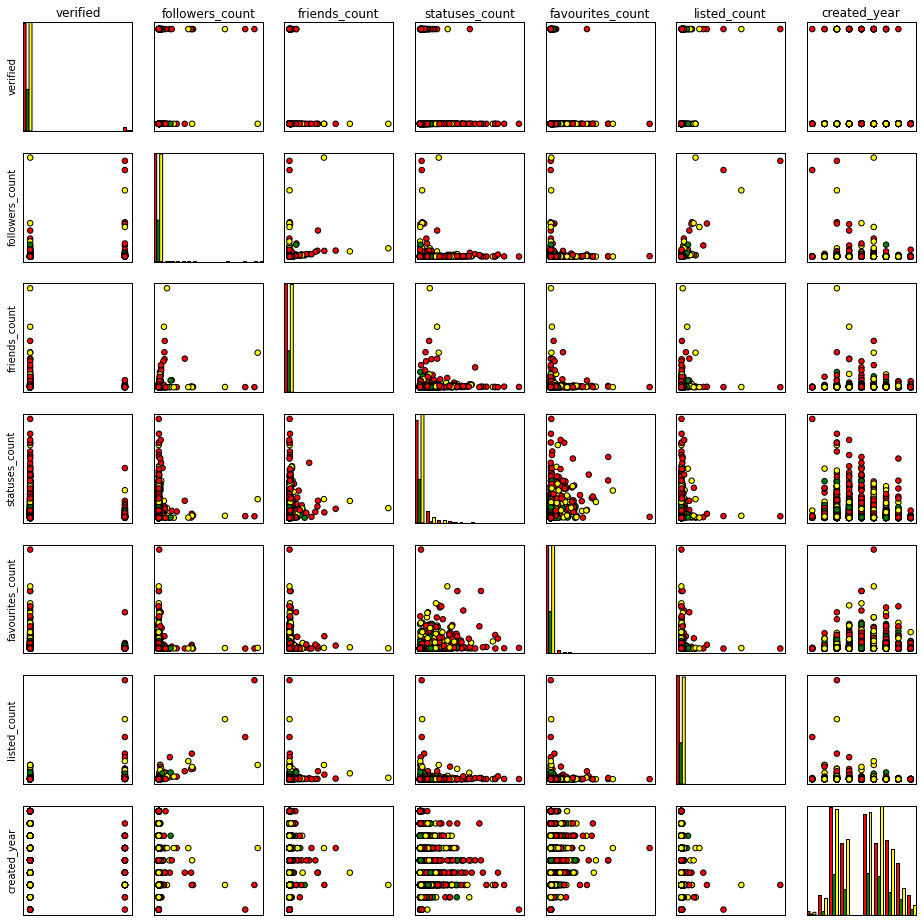

In [76]:
social_features_new = ["verified", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year"]
social_features = [f for f in social_features_new if f in features]

social_feature_ind = [features.index(i) for i in social_features]
plot_dataset(x[:, social_feature_ind], y, social_features)

Из графиков видно, что признаки "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count" сильно смещены в сторону небольших значений. В таком случае удобно сделать логарифмическое преобразрвание этих признаков, то есть применить к их значениям $x_{ij}$ функцию $\log(1 + x_{ij})$. Сделаем это и построим новые распределения ([подсказка](http://anokhin.github.io/img/hw2_social2.png)). Необходимо реализовать функцию log_transform_features, которая выполняет указанное логарифмическое преобразование.

In [77]:
import math

def log_transform_features(data, features, transformed_features):
    log_f = np.vectorize(lambda x: math.log(2 + x))
    inds = [features.index(i) for i in transformed_features]
    data[:, inds] = log_f(data[:, inds])
    return data

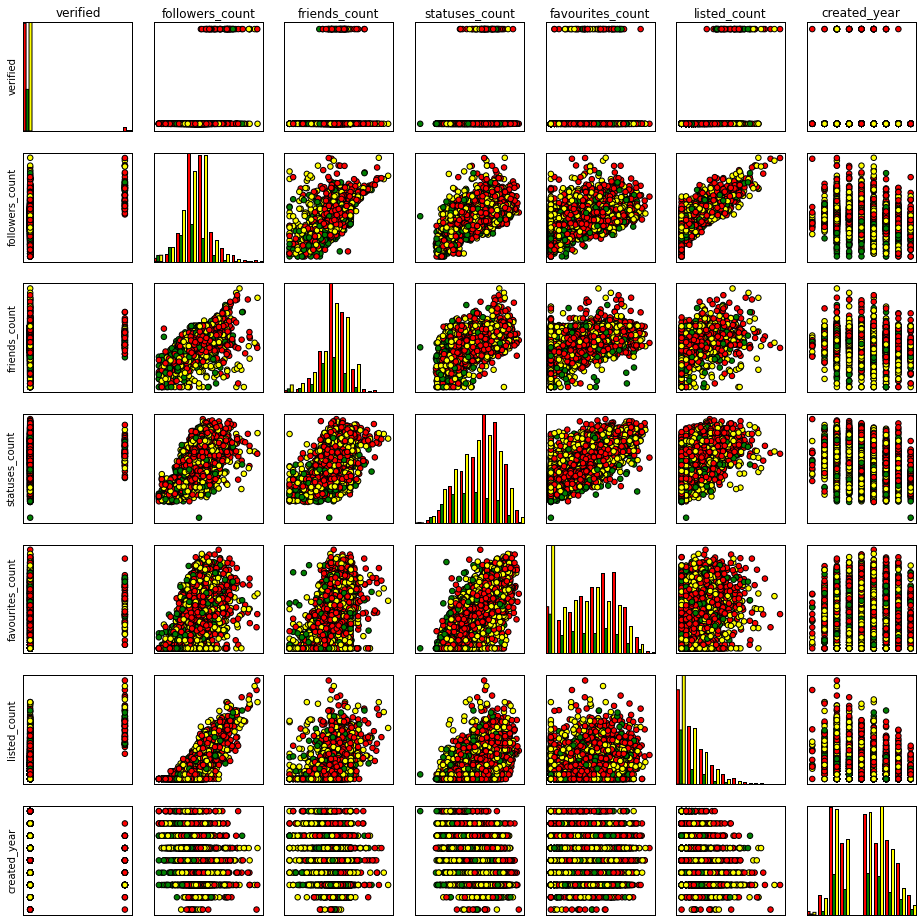

In [78]:
transformed_features = ["followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
x = log_transform_features(x, features, transformed_features)

# Re-plot features
plot_dataset(x[:, social_feature_ind], y, social_features)

Сразу бросается в глаза, что признак "verified" сильно смещен -- верифицированных пользователей очень мало. Более того, все верифицированные пользователи имеют много фолловеров, поэтому часть информации о верификации дублируется в признаке "followers_count". По этой причине в дальнейшем не будем рассмтаривать признак "verified".

После того как мы с помощью логарифмического преобразования избавились от сильной скошенности признаков, можно наблюдать некоторые интересные зависимости. Например, пользователи, имеющие много фолловеров, обязательно имеют много статусов. Следовательно, чтобы стать популярным, обязательно нужно много писать. Анализ других зависимостей остается как упражнение.

Наконец построим попарные распределения остальных признаков ([подсказка](http://anokhin.github.io/img/hw2_other.png)).

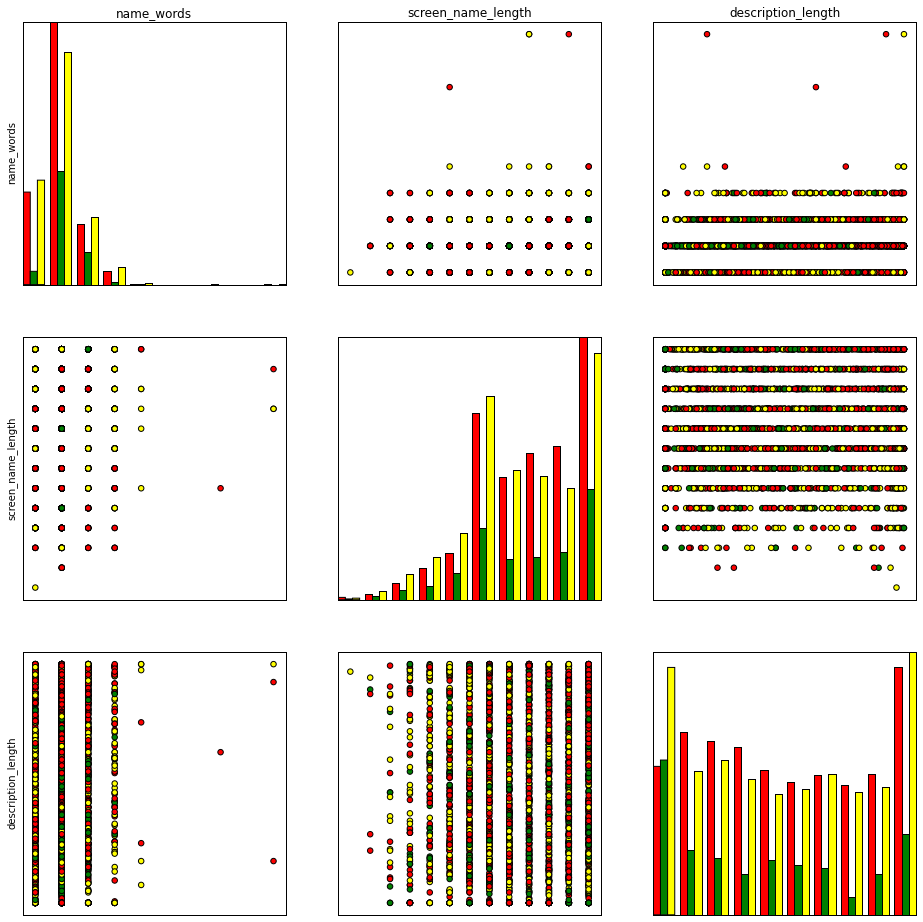

In [79]:
other_features_new = ["name_words", "screen_name_length", "description_length"]
other_features = [f for f in other_features_new if f in features]
other_feature_ind = [features.index(i) for i in other_features]
plot_dataset(x[:, other_feature_ind], y, other_features)

Итак после первичной обработки данных мы имеем 9 числовых признаков, каждый из которых распределен в некотором своем интервале. Для того, чтобы ни один признак не получил перевеса при кластеризации, нормализуем данные так, что каждый признак распределен на отрезке $[0, 1]$. 

In [80]:
selected_features_new = ["followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year", "name_words", "screen_name_length", "description_length"]
selected_features = [f for f in selected_features_new if f in features]
selected_features_ind = [features.index(i) for i in selected_features]

x_1 = x[:, selected_features_ind]

# Replace nan with 0-s
# Is there a smarter way?
# Yes, by using np.nan_to_num(X).
np.nan_to_num(x_1)
x_min = x_1.min(axis=0)
x_max = x_1.max(axis=0)
x_new = (x_1 - x_min) / (x_max - x_min)

Упакуем полученную матрицу в pandas DataFrame и сохраним в файл "hw2_out.csv". В следующем задании мы будем кластеризовать пользователей на оновании этих данных.

In [81]:
df_out = pd.DataFrame(data=x_new, index=df_users["twitter_id"], columns=[f for f in selected_features])
df_out.to_csv("files/hw2_out.csv", sep="\t")